# Credit Card Fraud  
https://www.kaggle.com/mlg-ulb/creditcardfraud

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

In [40]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain, combinations

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve

np.set_printoptions(suppress=True)
sns.set()

try:
    os.environ['KAGGLE_DATA_PROXY_TOKEN']
except KeyError:
    path = "creditcard.csv"
else:
    path = "/kaggle/input/creditcardfraud/creditcard.csv"

In [41]:
data = pd.read_csv(path)

In [84]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Are there missing values?

In [42]:
data.isna().any().any()

False

In [43]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ix, test_ix in split.split(data, data["Class"]):
    df_train = data.iloc[train_ix]
    df_test = data.iloc[test_ix]

In [87]:
X = df_train.drop(["Class"], axis=1)
[variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 

[2.3133811750545568,
 1.605542213704298,
 3.8051267607304413,
 1.2502333053551242,
 1.1354146757416699,
 2.731035079218942,
 1.5160352568722226,
 2.499565878518846,
 1.096719735598472,
 1.0183870045869816,
 1.115505143482334,
 1.0287522553087913,
 1.0123222644326195,
 1.003413355788527,
 1.025103531681537,
 1.0139398452535657,
 1.0004934351992474,
 1.0045012316933581,
 1.0066250379406934,
 1.0361905610165834,
 2.198732455379024,
 1.0972559800419155,
 1.08040645318751,
 1.1443548928308436,
 1.0007525939987847,
 1.013410390198266,
 1.0005629665788318,
 1.0102830032094259,
 1.0033362950869855,
 11.28459909657232]

Drop that one collinear feature.

In [44]:
df_train = df_train.drop(["Amount"], axis=1)
df_test = df_test.drop(["Amount"], axis=1)

Examine how the values for the features are distributed for both classes:

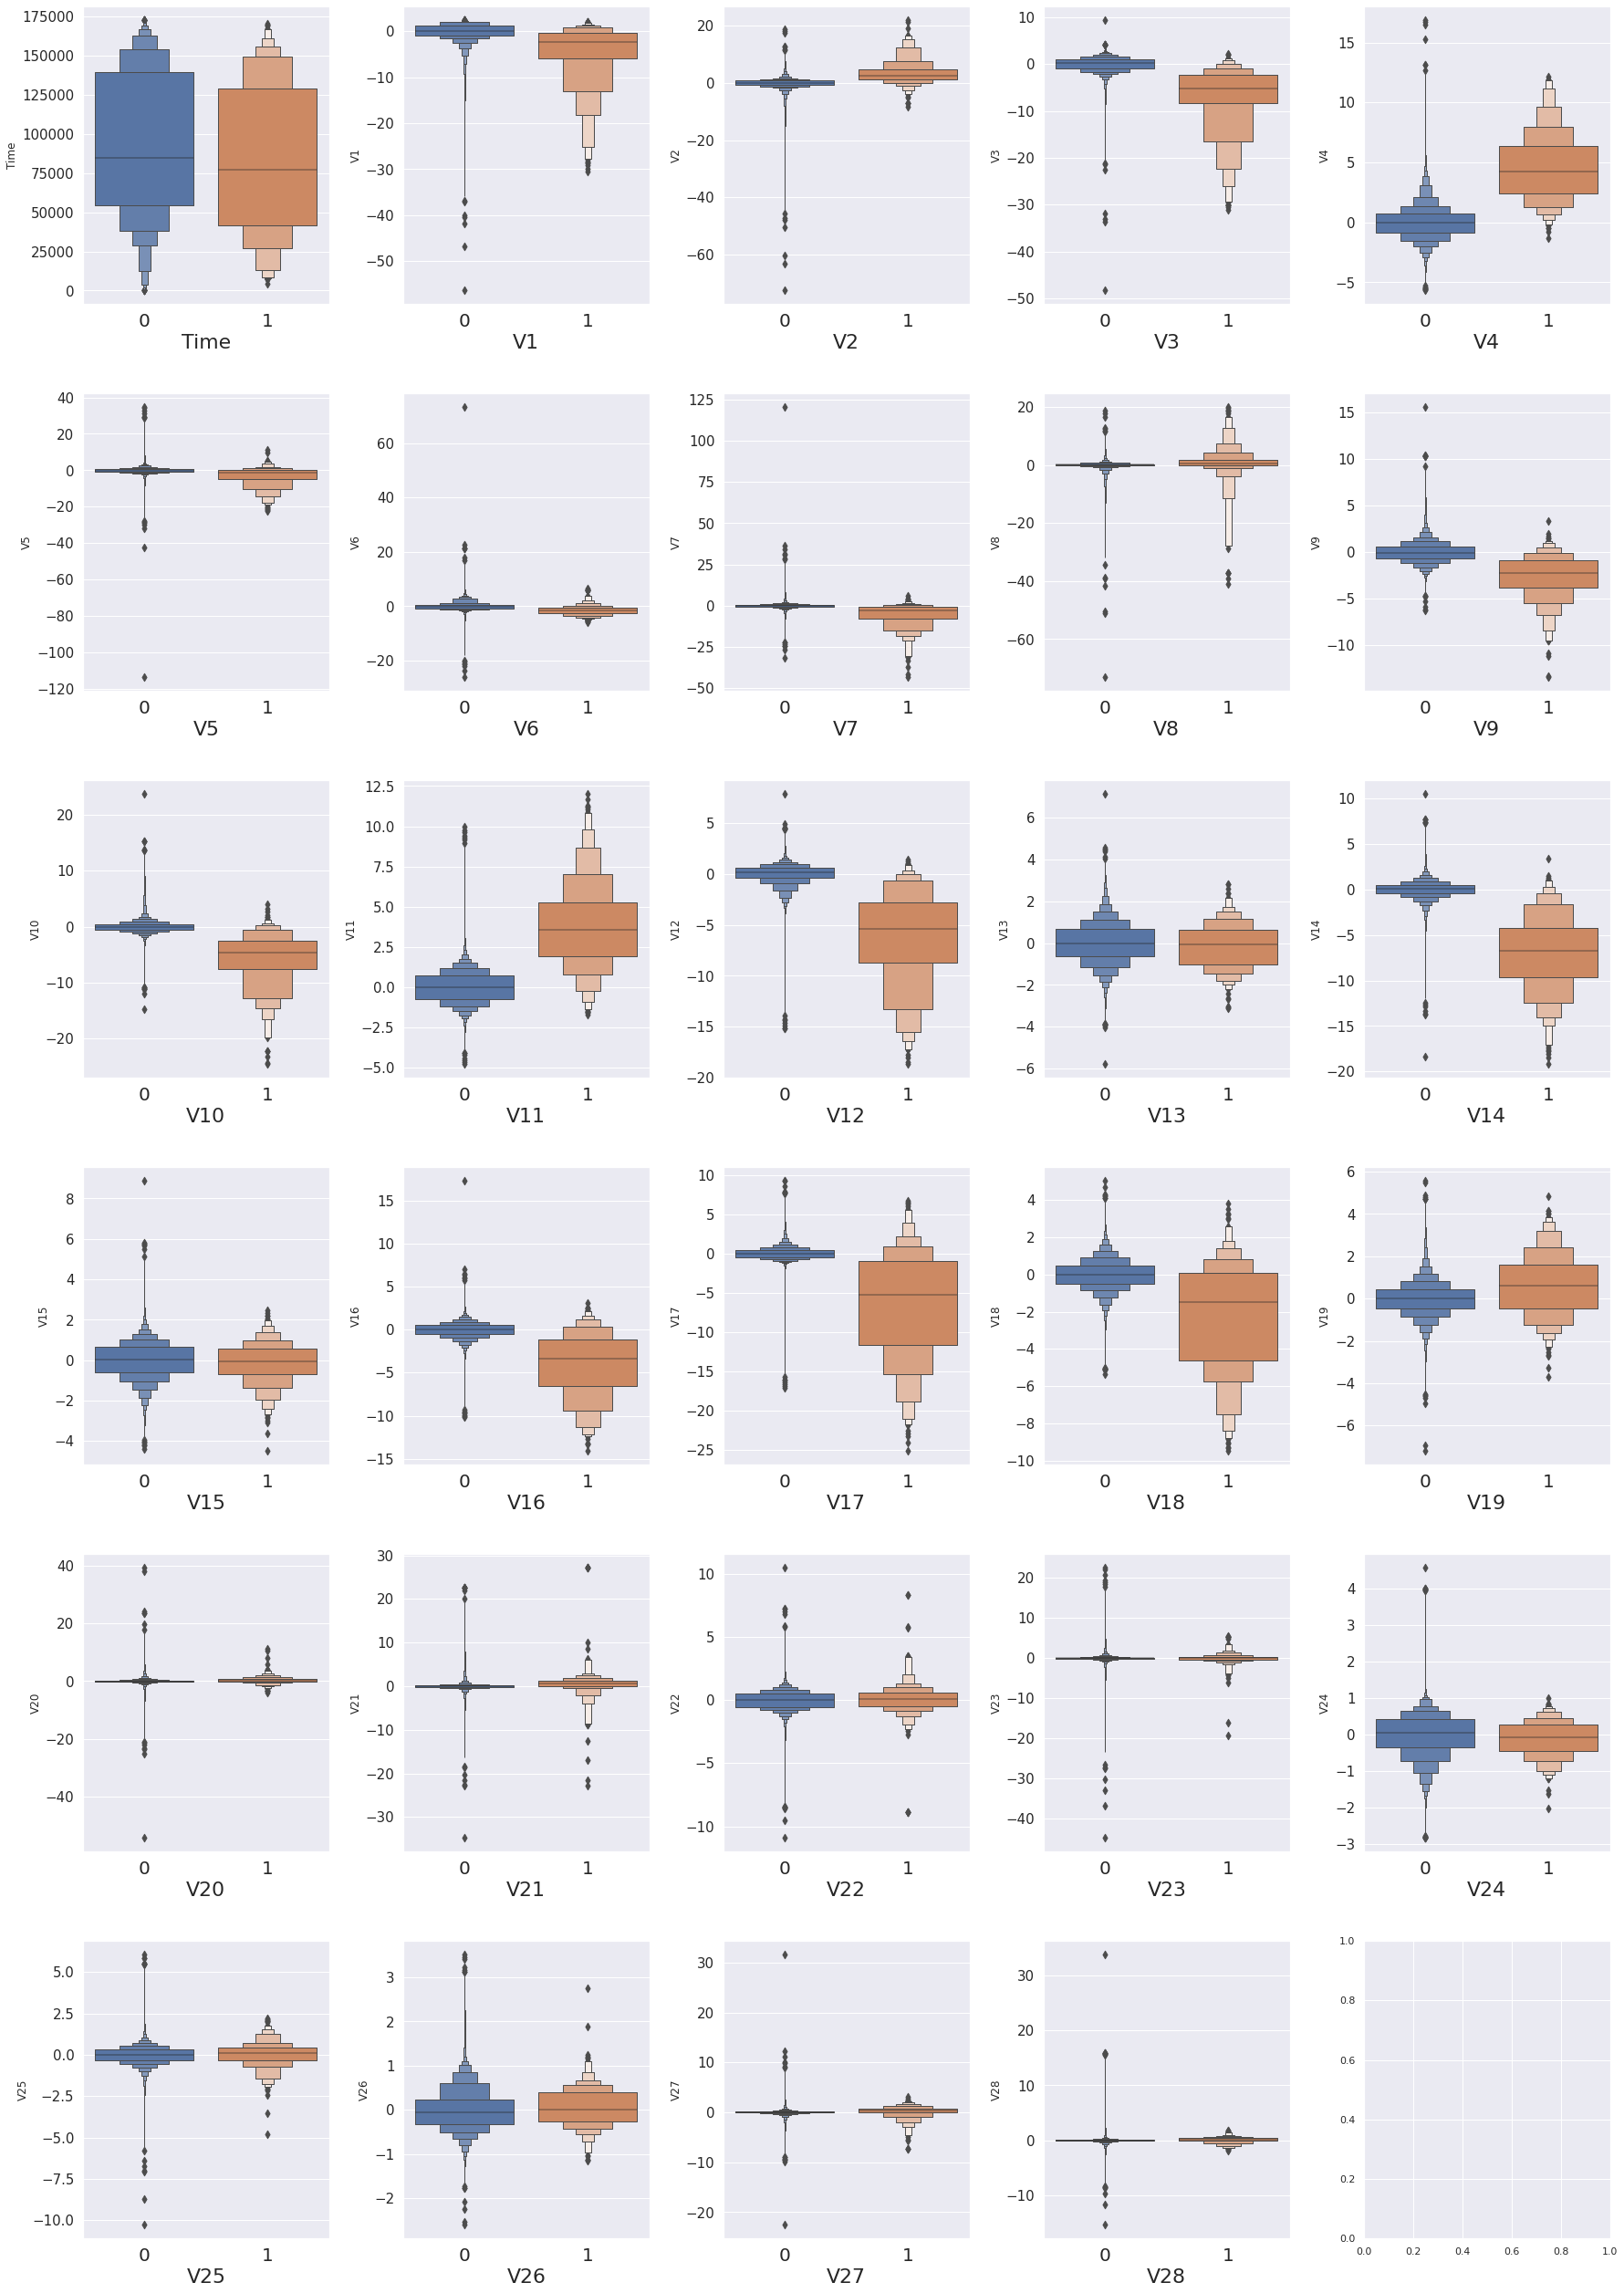

In [89]:
fig, axs = plt.subplots(6, 5, figsize = (30, 45))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for ix in range(len(df_train.drop(["Class"], axis=1).columns)):
    col = df_train.columns[ix]
    ax = axs.flat[ix]
    
    sns.boxenplot(x="Class", y=col, data=df_train, ax=ax)
    
#     label = ax.xaxis.get_label()
    ax.set_xlabel(col, fontsize=22)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)

Choose features where the classes look well separable. Used further down below.

In [45]:
cols = ["V1", "V3", "V4", "V11", "V12", "V14", "V16", "V17"]

## Assumption of model and distribution
Not knowing the original features and the result of the PCA still being high-dimensional makes assuming a distribution and a good model challenging.  
First, consider all features for outlier cleaning and a first model test.

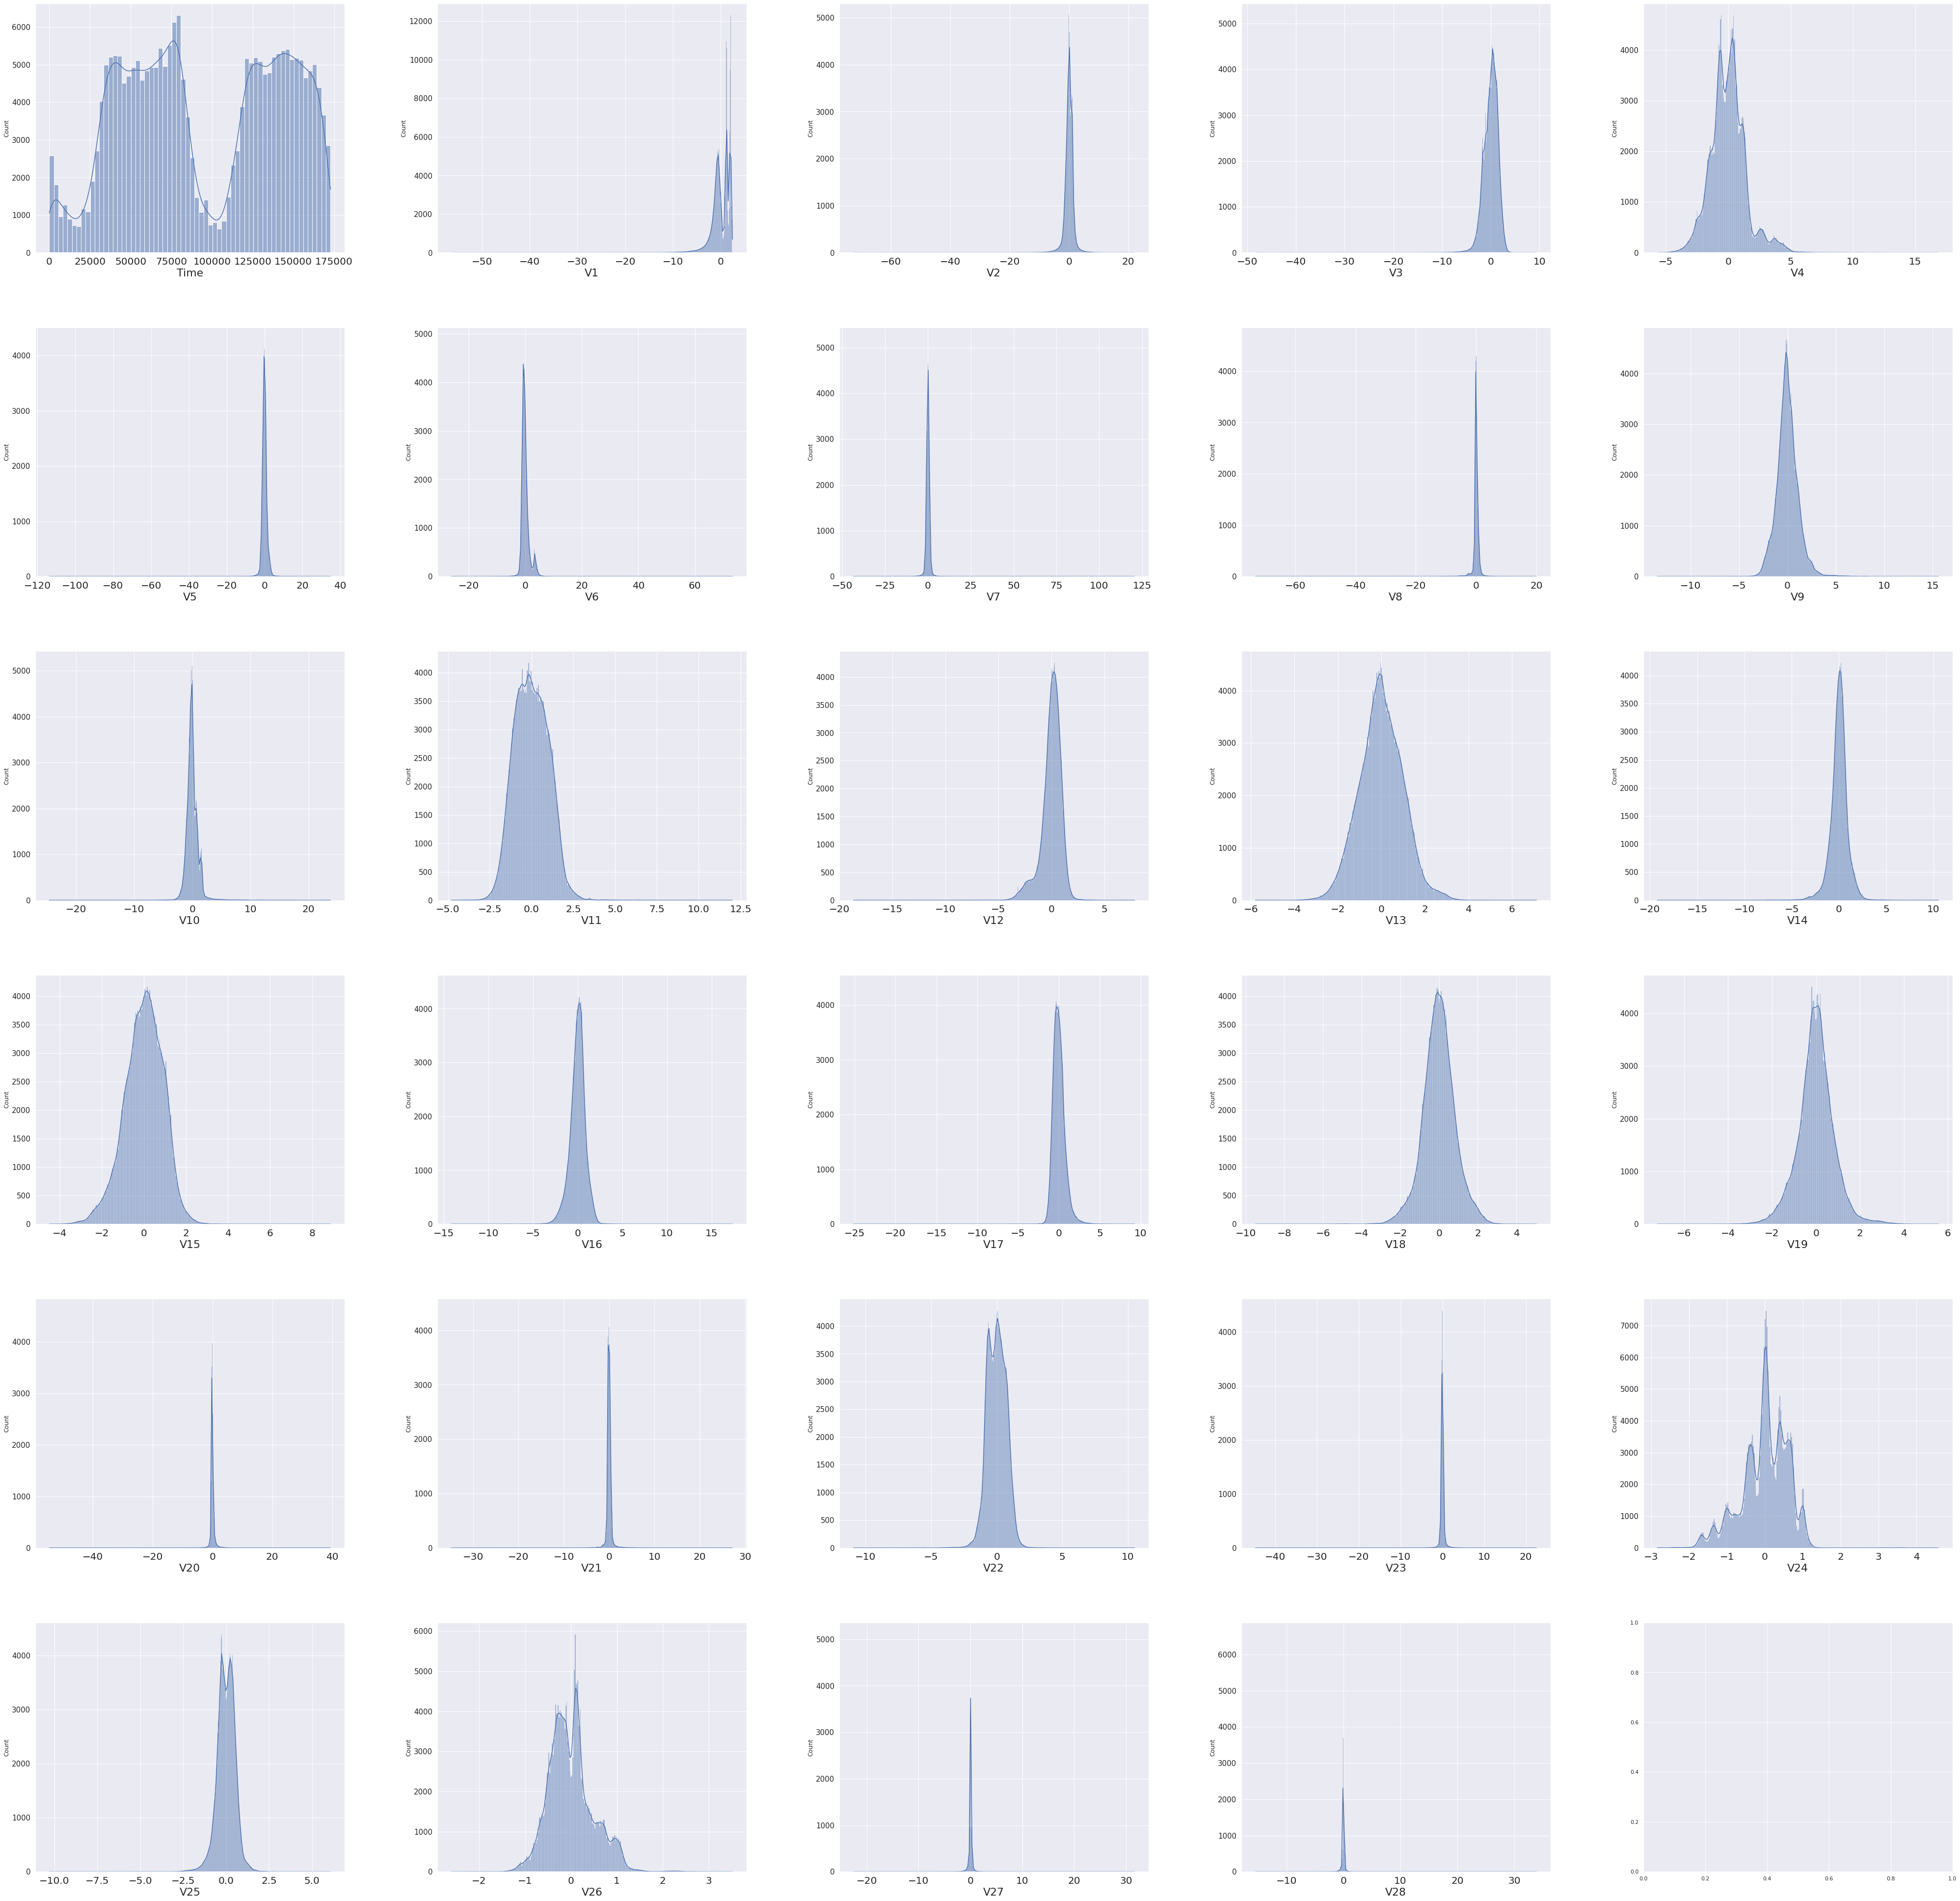

In [12]:
fig, axs = plt.subplots(6, 5, figsize = (70, 70))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for ix in range(len(df_train.drop(["Class"], axis=1).columns)):
    col = df_train.columns[ix]
    ax = axs.flat[ix]
    
    sns.histplot(x=df_train[col], kde=True, ax=ax)
    
    ax.set_xlabel(col, fontsize=22)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)

With almost all features we seem to have a multivariate normal distribution. So, to **clean outliers** next we should try Elliptic Envelope.

In [46]:
cols = cols[1:]
cols = ["V2", "V3", "V5", "V7", "V11", "V12", "V14", "V16", "V17"]
# cols = ['V2', 'V3', 'V5', 'V7', 'V8', 'V9', 'V10',
#        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
#        'V21', 'V23', 'V27', 'V28']

**LOF**

In [47]:
# outlier_clf = LocalOutlierFactor(novelty=True)
# map_vals = {1 : True, -1 : False}

# df_train_fraud = df_train.loc[df_train.Class == 1]

# outlier_clf.fit(df_train_fraud.drop(["Class"], axis=1))
# out_in = outlier_clf.predict(df_train_fraud.drop(["Class"], axis=1))
# mask_inliers = np.vectorize(map_vals.get)(out_in)

# df_fraud_inliers = df_train_fraud.loc[mask_inliers]


# df_train_nofraud = df_train.loc[df_train.Class == 0]

# outlier_clf.fit(df_train_nofraud.drop(["Class"], axis=1))
# out_in = outlier_clf.predict(df_train_nofraud.drop(["Class"], axis=1))
# mask_inliers = np.vectorize(map_vals.get)(out_in)

# df_nofraud_inliers = df_train_nofraud.loc[mask_inliers]

# print(outlier_clf.negative_outlier_factor_)

**Elliptic Envelope**

In [48]:
outlier_clf = EllipticEnvelope()
outlier_clf.fit(df_train[df_train.Class == 1][cols])
outliers = outlier_clf.predict(df_train[df_train.Class == 1][cols])
map_vals = {1 : True, -1 : False}
mask = np.vectorize(map_vals.get)(outliers)
df_fraud_inliers = df_train[df_train.Class == 1].loc[mask]
# df_fraud_inliers = df_train[df_train.Class == 1]

outlier_clf.fit(df_train[df_train.Class == 0][cols])
outliers = outlier_clf.predict(df_train[df_train.Class == 0][cols])
mask = np.vectorize(map_vals.get)(outliers)
df_nofraud_inliers = df_train[df_train.Class == 0].loc[mask]

In [78]:
# df_fraud_inliers = pd.concat([df_fraud_inliers, pd.Series([1] * len(df_fraud_inliers), name="Class")], axis=1)
# df_nofraud_inliers = pd.concat([df_nofraud_inliers, pd.Series([0] * len(df_nofraud_inliers), name="Class")], axis=1)

df_train_inliers = pd.concat([df_fraud_inliers, df_nofraud_inliers]).sample(frac=1)

X_train = df_train_inliers.loc[:,:"V28"]
y_train = df_train_inliers["Class"]
X_test = df_test.loc[:,:"V28"]
y_test = df_test["Class"]

sm = SMOTE(random_state=12)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
y_train = y_train_smote

# X_train = df_train.drop(["Class"], axis=1)
# y_train = df_train["Class"]
# X_test = df_test.drop(["Class"], axis=1)
# y_test = df_test["Class"]

In [81]:
std_scaler = StandardScaler()
# X_train_trans = std_scaler.fit_transform(X_train.drop(["Time"], axis=1))
X_train_trans = std_scaler.fit_transform(X_train_smote.drop(["Time"], axis=1))
X_test_trans = std_scaler.fit_transform(X_test.drop(["Time"], axis=1))

Find a combination of columns that gives the **best recall** (false negatives can't be tolerated here) and accuracy with an out-of-the-box classifier.

In [51]:
def powerset(l):
    return chain.from_iterable(combinations(l, x) for x in range(1, len(l) + 1))

In [52]:
# colset_scores = []

# for col_set in powerset(cols):
#     colset_trans = std_scaler.fit_transform(X_train[list(col_set)])
#     model.fit(colset_trans, y_train)
    
#     colset_test = std_scaler.fit_transform(X_test[list(col_set)])
#     pred = model.predict(colset_test)
    
#     colset_scores.append( (recall_score(y_test, pred), accuracy_score(y_test, pred), col_set))


In [53]:
# sorted(colset_scores, key=lambda tup: (tup[0], tup[1]))[-10:]

In [83]:
colset_trans = std_scaler.fit_transform(X_train_smote[cols])
colset_test_trans = std_scaler.fit_transform(X_test[cols])

In [55]:
# colset_test_trans = std_scaler.fit_transform(X_test[cols])
# pred_proba = model.predict_proba(colset_test_trans)
# pred = pred_proba[:, 1] > 0.3
# confusion_matrix(y_test, pred)

In [101]:
model = KNeighborsClassifier(p=1, n_neighbors=7, weights="distance", n_jobs=-1)

model.fit(colset_trans, y_train)

pred = model.predict(colset_test_trans)

confusion_matrix(y_test, pred)

array([[56584,   280],
       [   11,    87]])

In [42]:
# with cols cols = ['V2', 'V3', 'V5', 'V7', 'V8', 'V9', 'V10',
#        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
#        'V21', 'V23', 'V27', 'V28'] 
model = KNeighborsClassifier(p=1, n_neighbors=7, weights="distance", n_jobs=-1)

model.fit(colset_trans, y_train)

pred = model.predict(colset_test_trans)

confusion_matrix(y_test, pred)

array([[56845,    19],
       [   17,    81]])

In [84]:
# with  cols = ["V2", "V3", "V5", "V7", "V11", "V12", "V14", "V16", "V17"]
model = KNeighborsClassifier(p=1, n_neighbors=7, weights="distance", n_jobs=-1)

model.fit(colset_trans, y_train)

pred = model.predict(colset_test_trans)

confusion_matrix(y_test, pred)

array([[56735,   129],
       [   12,    86]])

In [84]:
# with SMOTE & cols = ["V2", "V3", "V5", "V7", "V11", "V12", "V14", "V16", "V17"]
model = KNeighborsClassifier(p=1, n_neighbors=7, weights="distance", n_jobs=-1)

model.fit(colset_trans, y_train)

pred = model.predict(colset_test_trans)

confusion_matrix(y_test, pred)

array([[ 7258, 49606],
       [    1,    97]])

The objective here is to strive towards 100% recall since no frauds should be unidentified.

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

# params = {
#     "n_neighbors" : [7,9],
#     "p" : [1,2,3],
#     "weights" : ["uniform", "distance"],
#     "metric" : ["minkowski", "chebyshev"]
# }

# gridcv = GridSearchCV(knn, params, cv=2, scoring="recall", return_train_score=True, n_jobs=-1)

# gridcv.fit(colset_trans, y_train)
# model = gridcv.best_estimator_



In [ ]:
# model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#                      metric_params=None, n_jobs=-1, n_neighbors=7, p=1,
#                      weights='distance')
# model.fit(colset_trans, y_train)
# pred = model.predict(colset_test_trans)
# confusion_matrix(y_test, pred)

In [ ]:
recall_score(y_test, pred)

In [ ]:
dbscan = DBSCAN?

In [ ]:
dbscan = DBSCAN()
dbscan.fit(X_train_trans, y_train)

In [ ]:
# pred_proba = model.predict_proba(colset_trans)
# precisions, recalls, thresholds = precision_recall_curve(y_train, pred_proba[:,1])

In [ ]:
# precisions, recalls, thresholds = precision_recall_curve(y_train, pred_proba[:,1])
# plt.plot(thresholds, precisions[:-1], c="r")
# plt.plot(thresholds, recalls[:-1], c="b")

In [ ]:
# plot_precision_recall_curve(model, colset_trans, y_train)

In [ ]:
# pred_proba = model.predict_proba(colset_test_trans)


In [ ]:
# pred = pred_proba[:, 1] > 0.1
# confusion_matrix(y_test, pred)

In [ ]:
# pred = model.predict(colset_trans)

# confusion_matrix(y_train, pred)